In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

import warnings

# Ignorieren von FutureWarnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Business Understanding

Die Folgenden Ziele sind ausgerichtet auf mittelfristigen Investoren mit einer Investitionsdauer von maximal 1–2 Jahren. 

1. **Identifikation von unterbewerteten Immobilien:** Das primäre Ziel des Regressionsmodells ist die präzise Vorhersage des fairen Verkaufspreises. Durch den Vergleich der Modellvorhersage mit den tatsächlichen Angebotspreisen sollen Häuser identifiziert werden, die signifikant unter dem Marktwert angeboten werden.

2. **Ermittlung von Renovierungsmaßnahmen:** Durch die Analyse der Einflussfaktoren soll ermittelt werden, welche Merkmale den größten Einfluss auf den Verkaufspreis haben. Das Ziel ist es, abzuleiten, welche der Renovierungsmaßnahmen den Wert eines Hauses am stärksten steigern, um es innerhalb des Anlagezeitraums gewinnbringend weiterzuverkaufen. Ein Beispiel für eine solche Maßnahme wäre möglicherweise die verbesserung der Qualität des Innenanstrichs des Hauses.

# 2. Data Exploration und Analyse

In [56]:
# Daten Einlesen
data_train = pd.read_csv('data_for_training.csv', sep=';')
data_test = pd.read_csv('data_for_test.csv', sep=';')

# Erste 10 Datensätze ausgeben
data_train.head(10)

,A_Index,Ausbaustufe,Baujahr,Besonderheiten,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Lage,QualInnenfarbe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis
0,1710,1 Ebene,1960,NaN,166,Durchschnitt,Durchschnitt,1428,Durchschnitt,NeuBerlin_B,3,Keine/Kaum,1960,2009,166,100088
1,1310,1 Ebene,1982,NaN,151,Durchschnitt,Durchschnitt,2365,Gut,NeuBerlin_B,2,Mittel,1982,2006,151,145148
2,2563,1 Ebene,1925,NaN,84,Schlecht,Schlecht,1004,Schlecht,NeuBerlin_A,3,Stark,1953,2011,84,48860
3,373,1 Ebene,1968,NaN,95,Durchschnitt,Durchschnitt,1314,Durchschnitt,NeuBerlin_C,5,Keine/Kaum,1968,2006,95,72349
4,1464,1 Ebene,1979,NaN,133,Gut,Gut,1080,Gut,NeuBerlin_C,5,Keine/Kaum,2007,2007,133,138313
5,776,"1,5 Ebenen",1951,NaN,114,Durchschnitt,Durchschnitt,962,Durchschnitt,NeuBerlin_C,2,Keine/Kaum,1953,2005,155,76230
6,1874,1 Ebene,1954,NaN,124,Durchschnitt,Durchschnitt,931,Schlecht,NeuBerlin_A,4,Keine/Kaum,1954,2008,124,84066
7,65,2 Ebenen,2003,NaN,70,Gut,Durchschnitt,217,Gut,NeuBerlin_A,1,Keine/Kaum,2003,2007,140,106907
8,2289,1 Ebene,1999,NaN,102,Durchschnitt,Durchschnitt,1660,Gut,NeuBerlin_B,2,Mittel,1999,2007,102,93837
9,2390,1 Ebene,1977,Pool,200,Gut,Schlecht,1440,Gut,NeuBerlin_C,2,Keine/Kaum,1977,2006,246,155623


Spalten: A_Index, Ausbaustufe, Baujahr, Besonderheiten, EG_qm, Gesamtqual, Gesamtzustand, Grundstueck_qm, Kellerhoehe, Lage, QualInnenfarbe, Steigung, Umgebaut, Verkaufsjahr, Wohnflaeche_qm, Z_Verkaufspreis

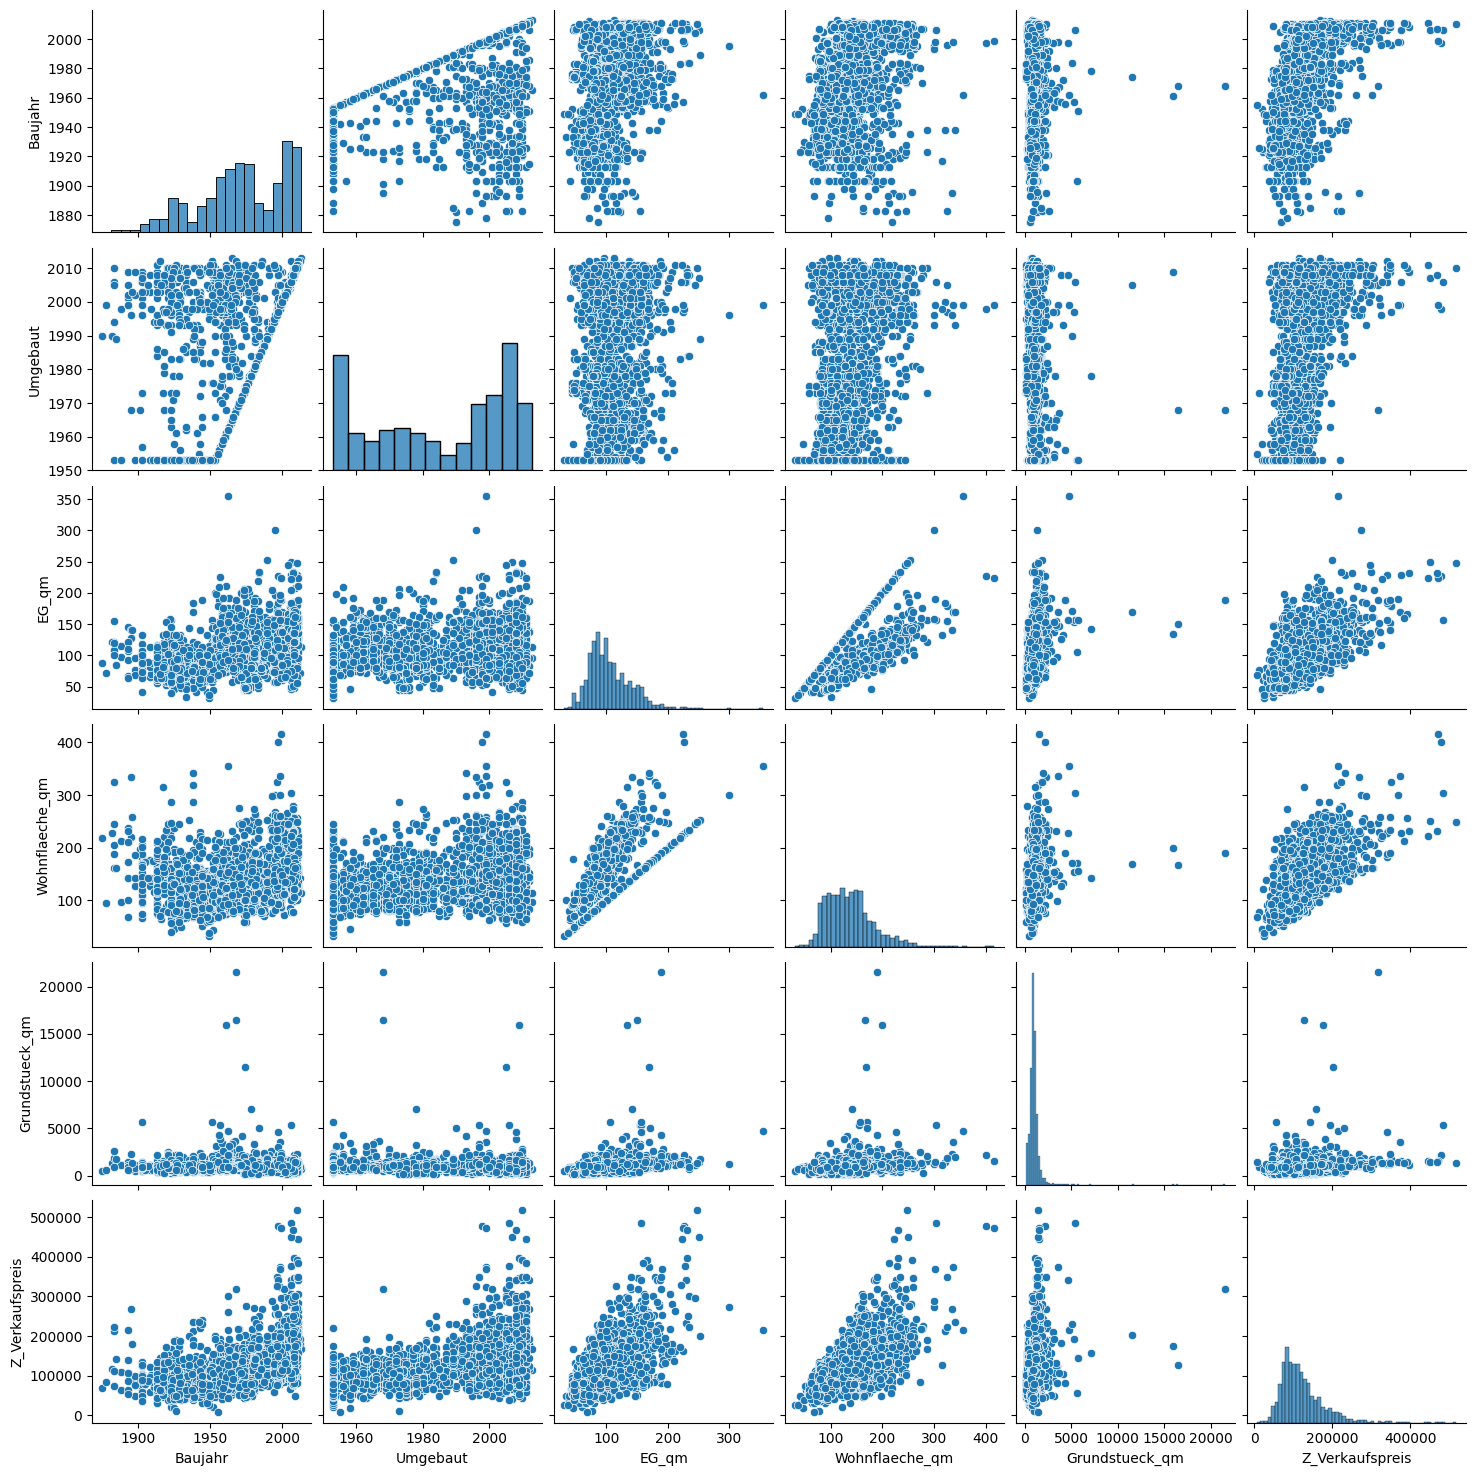

In [57]:
# Wähle gezielte numerische Spalten
land_vs_price = ['Baujahr', 'Umgebaut', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Z_Verkaufspreis']

# Scatterplot erstellen
scatterplot = sns.pairplot(data_train[land_vs_price])
scatterplot

Basierend auf den allgemeinen Scatterplots, welche die Numerischen Zusammenhänge darstellen, lassen sich folgende Hypothesen und Handlungen ableiten:

- **Preistreiber:** Es ist eine positive Korrelation zwischen `Wohnflaeche_qm` und dem `Z_Verkaufspreis` erkennbar
    - Die Beziehung wirkt weitgehend linear, zeigt aber bei sehr großen Flächen eine zunehmende Varianz
    - `EG_qm` scheint aus den selben gründen positiv mit `Z_Verkaufspreis` korreliert zu sein
- **Ausreißer:** Das Feature `Grundstueck_qm` zeigt massive Ausreißer (einzelne Punkte weit rechts von 5.000qm, jedoch Großteil der Daten < 5.000qm). Diese Ausreißer stauchen die Skala und erschweren das Lernen für lineare Modelle
    - Diese Ausreißer sind zu entfernen, oder zumindest auch zuvor ohne diese zu betrachten, um daraufhin eine Entscheidung über das Vorgehen treffen zu können
- **Alter und Preis:** Neuere Häuser (`Baujahr`) scheinen eher höhere Preise zu haben, die Streuung ist jedoch groß. Vermutbar ist, dass das Baujahr allein nicht reicht und allgemeine Zustand des Hauses (`Gesamtqual` und `Gesamtzustand`), sowie ob das Gebäude Rennoviert wurde (`Umgebaut`) ebenfalls eine Rolle spielt
    - Diese möglichen Zusammenhänge sind zu überprüfen
 - **Umbau:** Das Merkmal `Umgebaut` scheint sich ähnlichen Einfluss auf den Verkaufspreis wie das Merkmal `Baujahr` zu haben. Da Häuser, welche bisher nicht umgebaut wurden hier ihr Baujahr eingetragen haben erscheint dies auch logisch. Häuser welche seit langer zeit nicht umgebaut wurden scheinen einen eher geringeren Verkaufspreis zu haben.

#### Besonderheiten in den Plots
Einige der Plots zeigen unnatürliche Cutoffs in den Datensätzen. Bei genauerer Betrachtung lassen sich diese jedoch erklären.

Die Trennlinie von `Baujahr` mit `Umgebaut` lässt sich dadurch erklären, dass ein Haus erst umgebaut werden kann, nachdem es gebaut wurde. Ferner ist die Trennlinie bei `EG_qm` mit `Wohnfläche_qm` auch logisch. Die Wohnfläche eines Hauses kann in keinem Fall kleiner sein als die Fläche des Erdgeschosses.

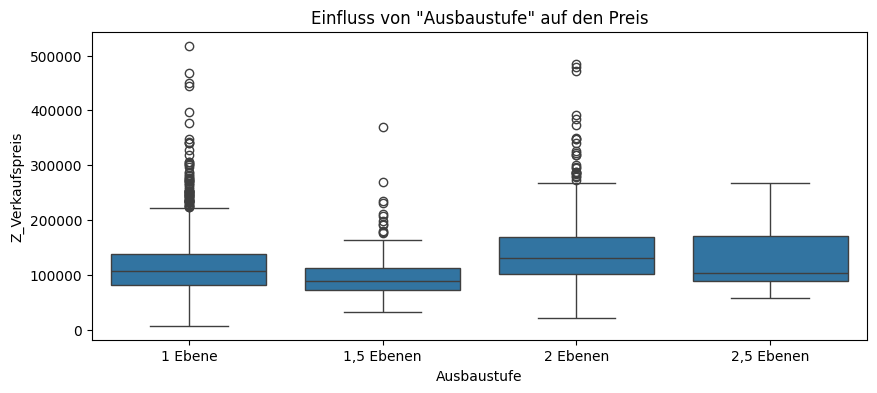

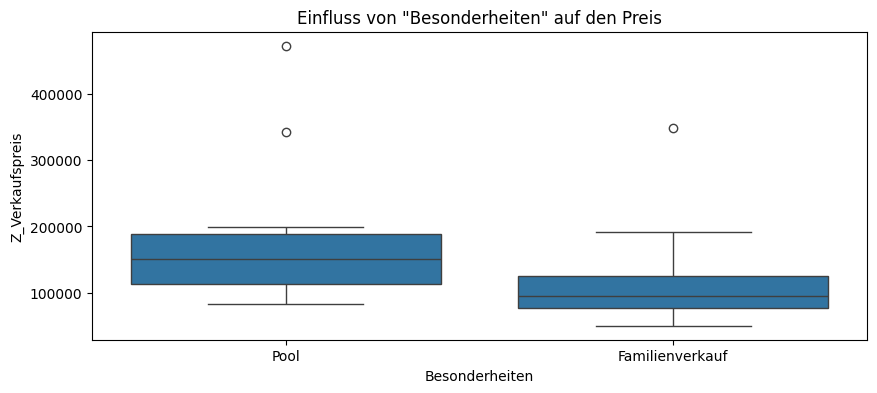

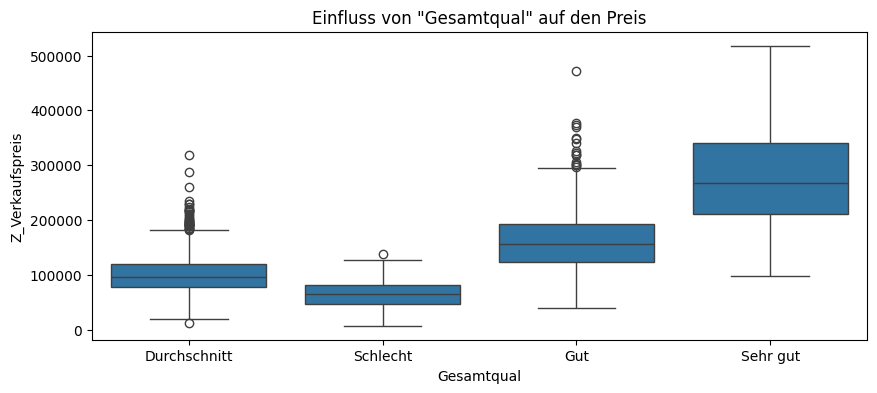

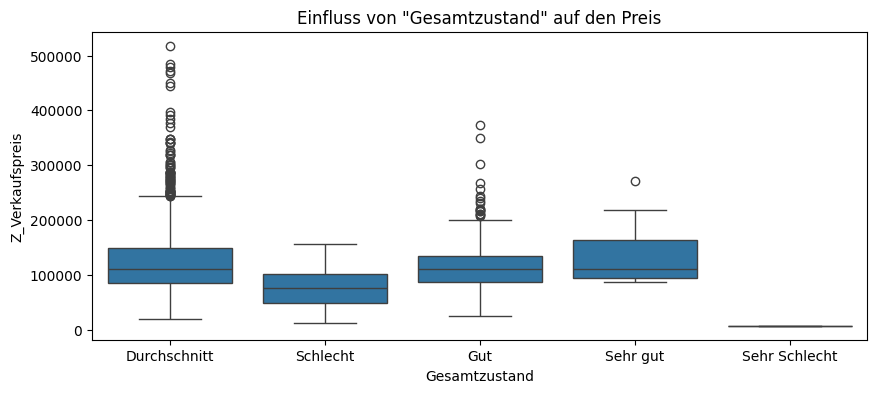

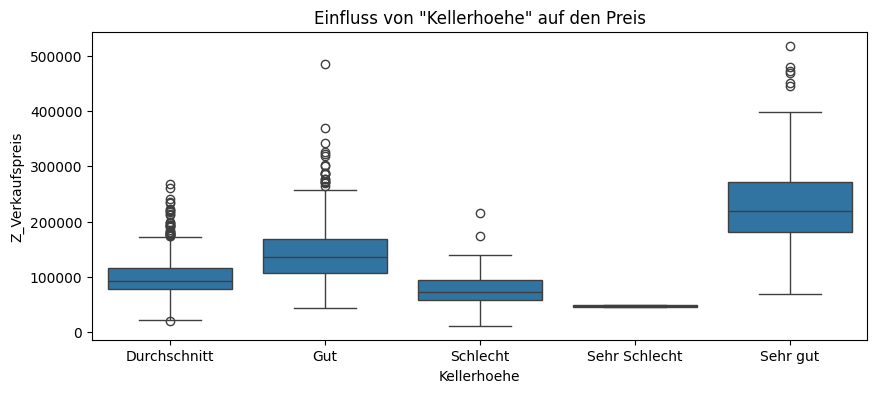

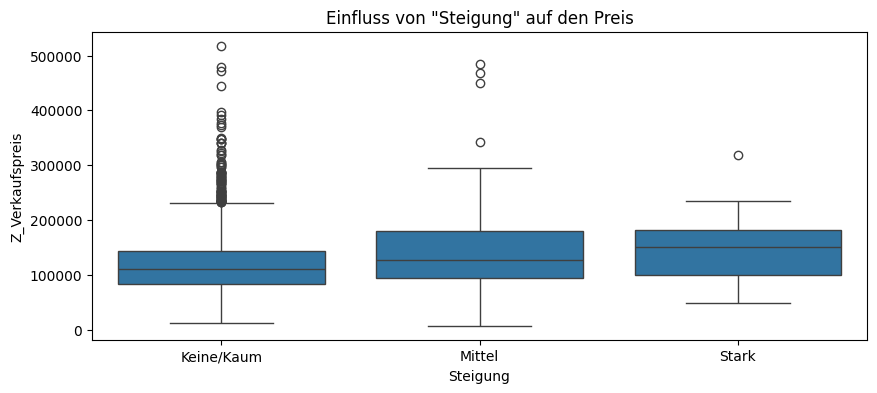

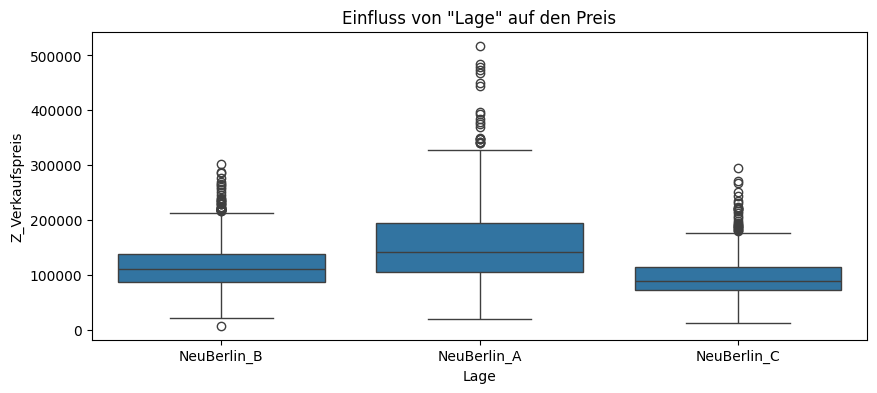

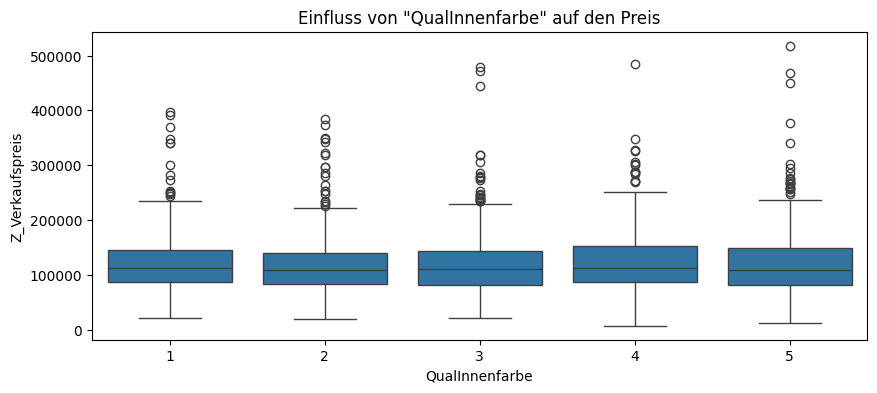

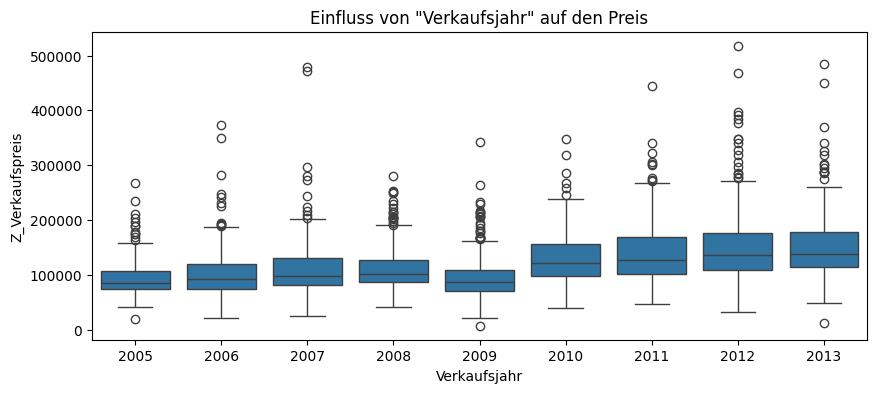

In [58]:
# Wähle kategorische Spalten
categorical = ['Ausbaustufe', 'Besonderheiten', 'Gesamtqual', 'Gesamtzustand', 'Kellerhoehe', 'Steigung', 'Lage', 'QualInnenfarbe', 'Verkaufsjahr']

# Für jede Kategorie einen Plot machen
for column in categorical:
    plt.figure(figsize=(10, 4))
    # Sortierung hilft beim Lesen (optional)
    sns.boxplot(x=column, y='Z_Verkaufspreis', data=data_train)
    plt.title(f'Einfluss von "{column}" auf den Preis')
    plt.show()

**2. Kategorische Einflüsse (Boxplots):**
- **Qualität:** Der Boxplot zu `Gesamtqual` zeigt, dass die Gesamtqualität des Hauses einen Unterschied macht. Je besser die Qualität, umso höher ist der Median-Preis. Die Boxen überlappen sich zudem kaum, was bedeutet, dass dieses Merkmal eine hohe Trennschärfe besitzt
- **Trend und Plausibilität:** Grundsätzlich ist der erwartete Trend erkennbar: Je besser der Zustand (von "Schlecht" zu "Sehr gut"), desto höher tendenziell der Median des Z_Verkaufspreis
    - Besonders die Kategorie "Sehr gut" hebt sich in beiden Merkmalen deutlich durch ein höheres Preisniveau und eine größere Varianz nach oben ab
    - Problem der Unterrepräsentation: Die Kategorie "Sehr Schlecht" zeigt in beiden Plots fast keine Varianz. Dies deutet stark darauf hin, dass hier nur extrem wenige Beobachtungen vorliegen
    - Diese spärliche Besetzung ist für ein Klassifikations-/Regressionsmodell problematisch, da es zu Overfitting auf diese wenigen Ausreißer führen kann
    - Um das Modell zu stabilisieren, sollten die Kategorie "Sehr Schlecht" mit der Kategorie "Schlecht" zusammengefasst werden
- **Steigung:** Häuser mit "Starker" `Steigung` haben einen etwas höheren Median als flache Grundstücke. Dies könnte mit einer besseren Aussicht (Hanglage) korrelieren
-  **Lage:** Geringer Einfluss
- **Besonderheiten:** Der Plot zu `Besonderheiten` zeigt nur "Pool" und "Familienverkauf". Ein Blick in die Rohdaten zeigt viele `NaN`-Werte
    - *Interpretation:* `NaN` bedeutet wahrscheinlich, dass ein Haus keine Besonderheit hat
    - Während der Data Preparaion sollten diese Zeilen nicht gelöscht werden, stattdessen sollten die `NaN`-Werte durch eine Kategorie wie "Standard" ersetzt werden
    - Ein Pool scheint den Preis signifikant zu heben, erkennbar durch den höheren Median
- **Kellerhöhe:** Es ist eine positive Tendenz erkennbar. Kategorien wie "Sehr gut" korrelieren mit deutlich höheren Verkaufspreisen als "Durchschnitt" oder "Schlecht"
    - Auffällig ist die hohe Varianz bei "Sehr gut": Eine sehr gute Kellerhöhe ermöglicht hohe Preise, garantiert sie aber nicht (die Box ist sehr lang gestreckt)
    - Die Kategorie "Sehr Schlecht" wird im Plot lediglich als flache Linie dargestellt. Dies ist ein Indikator für eine extrem geringe Fallzahl. Da diese Kategorie statistisch nicht signifikant ist, sollte sie mit der Kategorie "Schlecht" zusammengefasst werden, ähnlich 
- **Verkaufsjahr:** Geringe Tendenz, dass später verkaufte Häuser auch teurer verkauft wurden
    - *Interpretation*: Umso später ein Haus verkauft wird, umso neuer und somit moderner wird es vermutlich sein
    - Häuser im Jahr 2009 scheinen eine Ausnahe darzustellen, da hier der Verkaufspreis im Median sogar geringer ist als im Vorjahr
    - *Handlung:* Ob dies tatsächlich der Fall ist, beispielsweise durch die Finanzkriese zu dieser Zeit bedingt, ist der Preis pro Quadratmeter zu begutachten, um auszuschließen, dass 2009 nicht durch Zufall nur günstigere Häuser verkauft wurden (somit Selection Bias vermeiden)
- **Ohne/Wenig Einfluss:**
    - Das Merkmal `Ausbaustufe` scheint nicht logisch mit dem Verkaufspreis korreliert zu sein, die Boxplots zeigen, dass mehr Ebenen nicht direkt einen höheren Verkaufspreis zur folge haben
    - Das Merkmal `QualInnenfarbe` hat den Boxplots zu urteilen keinen Einfluss auf den Verkaufspreis

## 2.1 Betrachtung der Daten ohne Außreiser in `Grundstueck_qm`

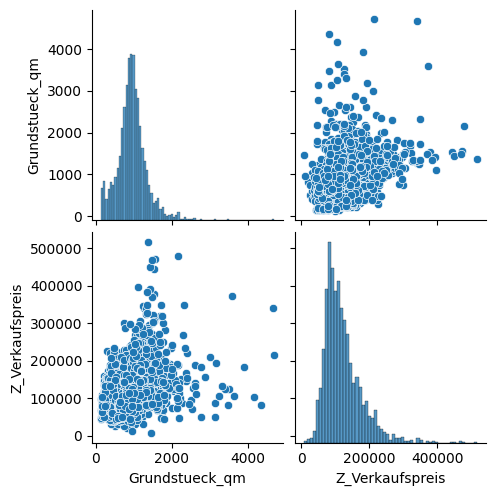

In [59]:
land_vs_price = ['Grundstueck_qm', 'Z_Verkaufspreis']

# Filtering: Wir behalten nur Einträge unter 5.000 qm
data_train_filtered = data_train[data_train['Grundstueck_qm'] < 5000].copy()

scatterplot = sns.pairplot(data_train_filtered[land_vs_price])
plt.show()

**Auswertung:**
Wie vermutet, wird nun eine positive Korrelation sichtbar. Tendenziell führen größere Grundstücke zu höheren Verkaufspreisen. Trotz des erkennbaren Trends ist die Streuung der Datenpunkte sehr hoch. Dies deutet darauf hin, dass die Grundstücksgröße zwar einen Einfluss auf den Basispreis hat, aber alleine als Merkmal nicht aussagekräftig genug zur Vorhersage des Verkaufspreises ist. In der Phase der Data Preparation sind diese Außreiser tatsächlich zu filern.

## 2.2 Analyse des Preisabfalls im Verkaufsjahr 2009

Zuvor betrachten wir, ob die in 2009 verkauften Häuser nicht zufällig eine geringere Wohnfläche hatten, im Vergleich zu den restlichen Jahren.

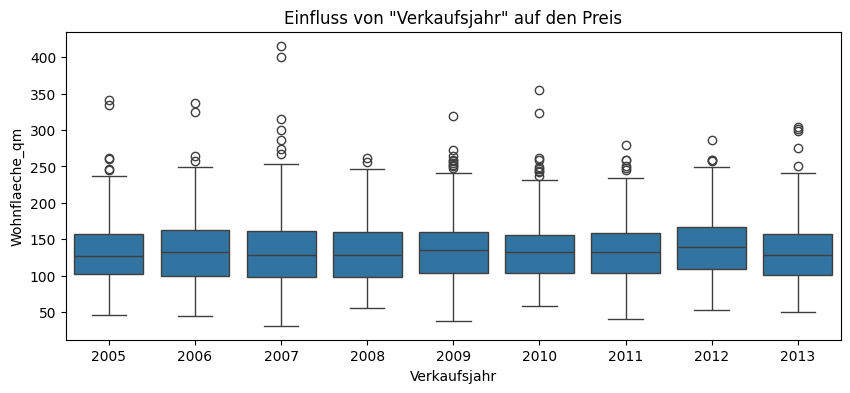

In [60]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Wohnflaeche_qm', data=data_train)
plt.title(f'Einfluss von "Verkaufsjahr" auf den Preis')
plt.show()

Nun betrachten wir den Quadratmeterpreis in den verschiedenen Verkaufsjahren.

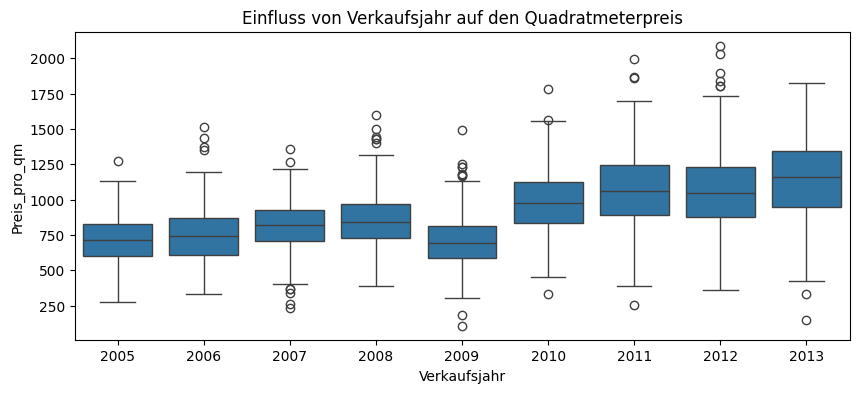

In [61]:
data_train['Preis_pro_qm'] = data_train['Z_Verkaufspreis'] / data_train['Wohnflaeche_qm']

plt.figure(figsize=(10, 4))
sns.boxplot(x='Verkaufsjahr', y='Preis_pro_qm', data=data_train)
plt.title('Einfluss von Verkaufsjahr auf den Quadratmeterpreis')
plt.show()

**Auswertung:**
Der Preisrückgang im Jahr 2009 scheint tatsächlich durch eine Finanzkriese bedingt zu sein, da der Quadratmeterpreis sinkt, während die verkaufte Wohnfläche konstant bleibt.

## 2.3 Fehlende Werte bei `Besonderheiten`

Die `NaN`-Werte aus dem Merkmal Besonderheiten werden der Kategorie "Standard" zugeordnet um sie somit auch analysieren zu können.

In [62]:
# NaN Werte durch 'Standard' ersetzen
data_train['Besonderheiten'] = data_train['Besonderheiten'].fillna('Standard')

# Check
print(data_train['Besonderheiten'].value_counts())

Besonderheiten
Standard           2331
Familienverkauf      43
Pool                 10
Name: count, dtype: int64


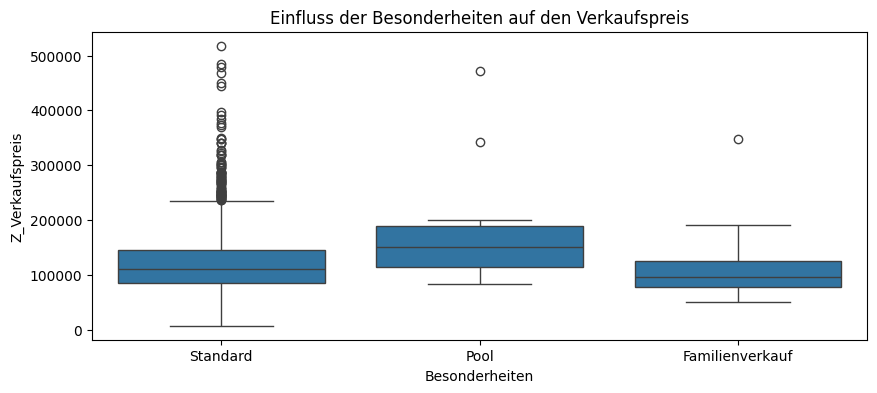

In [63]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Besonderheiten', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Besonderheiten auf den Verkaufspreis')
plt.show()

## 2.4 Erkenntnis nach Binning 

Folgende Zelle wurde als Teil der Data Preparation ausgeführt.

In [64]:
# Definition des Mappings: "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Kellerhoehe'] = data_train['Kellerhoehe'].replace(cleanup_map)
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].replace(cleanup_map)

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' nan]


Hier zeigt sich, dass Häuser ohne Keller für das Merkmal `Kellerhoehe` den Wert `NaN` eingetragen haben, somit erschienen diese Häuser bisher nicht in dem Boxplot, welcher den Zusammenhang zwischen Kellerhöhe und Verkaufspreis untersuchte. So wie zuvor für das Merkmal `Besonderheiten` geschehen sind nun auch hier die `NaN`-Werte einer Kategorie zuzuordnen.

In [65]:
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].fillna('Kein Keller')
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].fillna('Kein Keller')

print("Werte für Kellerhoehe:", data_train['Kellerhoehe'].unique())

Werte für Kellerhoehe: ['Durchschnitt' 'Gut' 'Schlecht' 'Sehr gut' 'Kein Keller']


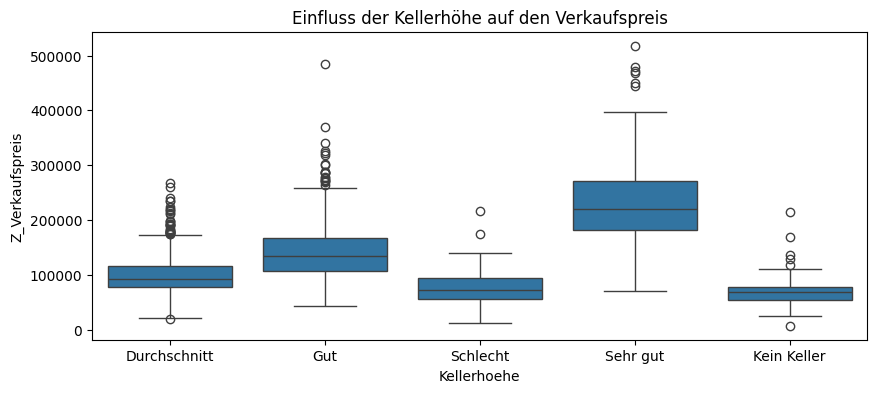

In [66]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Kellerhoehe', y='Z_Verkaufspreis', data=data_train)
plt.title('Einfluss der Kellerhöhe auf den Verkaufspreis')
plt.show()

**Auswertung:** Der Plot zeigt nun, dass Häuser ohne Keller einen geringeren Verkaufspreis haben zu scheinen, oder zumindest ähnlich zu Häusern mit schlechter Kellerhöhe. Diese Auswertung entspricht der Intuition.

## 2.5 Analyse der numerischen Merkmale für Feature Scaling
Um eine fundierte Entscheidung über das Feature Scaling treffen zu können, wurden die Schiefe (Skewness) und die deskriptiven Statistiken der numerischen Merkmale analysiert.

In [67]:
print('Skewness:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].skew())
print('Description:')
print(data_train[['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm']].describe())

Skewness:
Baujahr           -0.535609
EG_qm              1.072032
Wohnflaeche_qm     1.018008
Grundstueck_qm    13.554205
dtype: float64
Description:
           Baujahr        EG_qm  Wohnflaeche_qm  Grundstueck_qm
count  2384.000000  2384.000000     2384.000000     2384.000000
mean   1971.017198   104.883389      136.684144     1014.106544
std      29.620103    34.216459       45.470373      820.408957
min    1875.000000    31.000000       31.000000      132.000000
25%    1953.000000    80.000000      101.000000      746.750000
50%    1973.000000    98.000000      132.000000      942.000000
75%    1999.000000   124.000000      160.000000     1149.250000
max    2013.000000   355.000000      416.000000    21530.000000


**Auswertung:** Da die Wertebereiche der Merkmale stark variieren (z.B. Baujahr ~2000 vs. Wohnfläche ~100), ist eine Skalierung für viele Machine-Learning-Algorithmen (wie Lineare Regression) zwingend erforderlich. Da die Merkmale `EG_qm`, `Wohnflaeche_qm` und `Grundstueck_qm` eine deutliche Rechtsschiefe aufweisen, kann eine zusätzliche Log-Transformation vor dem Scaling bessere Ergebnisse liefern.

# 3. Data Preparation

## 3. Filtern der Außreiser von `Grundstueck_qm`

Da sich das Filtern der Außreißer in Kapitel 2.1 als sinnvoll erwiesen hat, wenden wir den Filter nun auf unsere tatsächlichen Daten an.

In [68]:
# Speichern der ursprünglichen Anzahl, um zu sehen, wie viele Datenpunkte entfernt werden
rows_before = data_train.shape[0]

# Filtern
data_train = data_train[data_train['Grundstueck_qm'] < 5000]

rows_after = data_train.shape[0]

print(f"Gelöschte Ausreißer: {rows_before - rows_after}")

Gelöschte Ausreißer: 10


## 3.1 Binning von Kategorien mit wenigen Datenpunkten

In [69]:
# "Sehr Schlecht" wird zu "Schlecht"
cleanup_map = {'Sehr Schlecht': 'Schlecht'}

data_train['Gesamtzustand'] = data_train['Gesamtzustand'].replace(cleanup_map)
data_test['Gesamtzustand'] = data_test['Gesamtzustand'].replace(cleanup_map)

print("Werte für Gesamtzustand:", data_train['Gesamtzustand'].unique())

Werte für Gesamtzustand: ['Durchschnitt' 'Schlecht' 'Gut' 'Sehr gut']


Für die Kellerhöhe wurde dieser Schritt bereits in Kaptiel 2.4 erledigt.

## 3.2 Entfernen irrelevanter Merkmale

Da die Merkmale A-Index sowie die Qualität der Innenfarbe keinen logischen Zusammenhang oder Mehrwert in der Analyse zeigten, werden diese entfernt.

Obwohl das Merkmal Ausbaustufe ebenfalls keinen linearen Zusammenhang gezeigt hat, darf dieses nicht gelöscht werden, da die Boxplots signifikante Unterschiede zwischen spezifischen Kategorien offenbarten. Diese nicht-linearen Informationen sind für baumbasierte Modelle wertvoll. Zudem wird dieses Merkmal für die Klassifikationsaufgabe zwingend benötigt.

In [70]:
drop_cols = ['QualInnenfarbe', 'A_Index']

data_train = data_train.drop(drop_cols, axis=1, errors='ignore')
data_test = data_test.drop(drop_cols, axis=1, errors='ignore')

## 3.3 Feature-Engineering "Preis pro Quadratmeter"

Um die Datenqualität zu überprüfen, wurde temporär das Merkmal `Preis_pro_qm` abgeleitet (Verkaufspreis / Wohnfläche). Da dieses Merkmal den Zielwert `Z_Verkaufspreis` direkt beinhaltet, wurde es ausschließlich für die Analyse und Bereinigung verwendet und nicht als Feature in das Training der Vorhersagemodelle aufgenommen, um Data Leakage zu vermeiden. Somit wird dieses Feature wieder entfernt.

In [71]:
data_train = data_train.drop('Preis_pro_qm', axis=1, errors='ignore')

print("Spalte 'Preis_pro_qm' erfolgreich entfernt." if 'Preis_pro_qm' not in data_train.columns else "Fehler beim Entfernen.")

Spalte 'Preis_pro_qm' erfolgreich entfernt.


## 3.4 Encoding Kategorischer Merkmale

Um die kategorischen Merkmale für die Modellierung vorzubereiten, werden diese mittels One-Hot-Encoding für nominale Merkmale und Label-Encoding für ordinale Merkmale in numerische Merkmale umgewandelt. Dies ermöglicht es den Modellen, die kategorialen Informationen effektiv zu nutzen.

In [72]:
# Definition der Mappings für Ordinale Merkmale
quality_map = {'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}
steigung_map = {'Keine/Kaum': 1, 'Mittel': 2, 'Stark': 3}
keller_map = {'Kein Keller': 0, 'Schlecht': 1, 'Durchschnitt': 2, 'Gut': 3, 'Sehr gut': 4}
stockwerke_map = {'1 Ebene': 1.0, '1,5 Ebenen': 1.5, '2 Ebenen': 2.0, '2,5 Ebenen': 2.5}

# Anwenden der Ordinalen Encodings
data_train['Gesamtqual'] = data_train['Gesamtqual'].map(quality_map)
data_train['Gesamtzustand'] = data_train['Gesamtzustand'].map(quality_map)
data_train['Kellerhoehe'] = data_train['Kellerhoehe'].map(keller_map)
data_train['Steigung'] = data_train['Steigung'].map(steigung_map)
data_train['Ausbaustufe'] = data_train['Ausbaustufe'].map(stockwerke_map)

data_test['Gesamtqual'] = data_test['Gesamtqual'].map(quality_map)
data_test['Gesamtzustand'] = data_test['Gesamtzustand'].map(quality_map)
data_test['Kellerhoehe'] = data_test['Kellerhoehe'].map(keller_map)
data_test['Steigung'] = data_test['Steigung'].map(steigung_map)
data_test['Ausbaustufe'] = data_test['Ausbaustufe'].map(stockwerke_map)

# Nominal Encoding (One-Hot Encoding) für 'Besonderheiten' und 'Lage'
# drop_first=True um Multikollinearität zu vermeiden (Dummy Trap)
data_train = pd.get_dummies(data_train, columns=['Besonderheiten', 'Lage'], drop_first=False)
data_test = pd.get_dummies(data_test, columns=['Besonderheiten', 'Lage'], drop_first=False)

data_test = data_test.reindex(columns=data_train.columns, fill_value=False)
data_test = data_test.drop('Z_Verkaufspreis', axis=1, errors='ignore')

# Überprüfung der Datentypen und ersten Zeilen
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 0 to 2383
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Ausbaustufe                     2374 non-null   float64
 1   Baujahr                         2374 non-null   int64  
 2   EG_qm                           2374 non-null   int64  
 3   Gesamtqual                      2374 non-null   int64  
 4   Gesamtzustand                   2374 non-null   int64  
 5   Grundstueck_qm                  2374 non-null   int64  
 6   Kellerhoehe                     2374 non-null   int64  
 7   Steigung                        2374 non-null   int64  
 8   Umgebaut                        2374 non-null   int64  
 9   Verkaufsjahr                    2374 non-null   int64  
 10  Wohnflaeche_qm                  2374 non-null   int64  
 11  Z_Verkaufspreis                 2374 non-null   int64  
 12  Besonderheiten_Familienverkauf  2374 no

,Ausbaustufe,Baujahr,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis,Besonderheiten_Familienverkauf,Besonderheiten_Pool,Besonderheiten_Standard,Lage_NeuBerlin_A,Lage_NeuBerlin_B,Lage_NeuBerlin_C
0,1.0,1960,166,2,2,1428,2,1,1960,2009,166,100088,False,False,True,False,True,False
1,1.0,1982,151,2,2,2365,3,2,1982,2006,151,145148,False,False,True,False,True,False
2,1.0,1925,84,1,1,1004,1,3,1953,2011,84,48860,False,False,True,True,False,False
3,1.0,1968,95,2,2,1314,2,1,1968,2006,95,72349,False,False,True,False,False,True
4,1.0,1979,133,3,3,1080,3,1,2007,2007,133,138313,False,False,True,False,False,True


In [73]:
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Ausbaustufe                     265 non-null    float64
 1   Baujahr                         265 non-null    int64  
 2   EG_qm                           265 non-null    int64  
 3   Gesamtqual                      265 non-null    int64  
 4   Gesamtzustand                   265 non-null    int64  
 5   Grundstueck_qm                  265 non-null    int64  
 6   Kellerhoehe                     265 non-null    int64  
 7   Steigung                        265 non-null    int64  
 8   Umgebaut                        265 non-null    int64  
 9   Verkaufsjahr                    265 non-null    int64  
 10  Wohnflaeche_qm                  265 non-null    int64  
 11  Besonderheiten_Familienverkauf  265 non-null    bool   
 12  Besonderheiten_Pool             265 

## 3.5 Feature Scaling
Die numerischen Merkmale weisen unterschiedliche Wertebereiche und Verteilungen auf. Um die Leistung der Machine-Learning-Modelle zu verbessern, wird ein Feature Scaling durchgeführt. Hierbei wird der StandardScaler verwendet, der die Merkmale so transformiert, dass sie einen Mittelwert von 0 und eine Standardabweichung von 1 aufweisen.

In [74]:
from sklearn.preprocessing import StandardScaler

# Numerische Spalten definieren
numerical_cols = ['Baujahr', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Verkaufsjahr']

# Scaler initialisieren und anwenden
scaler = StandardScaler()
X_log = np.log1p(data_train[numerical_cols])
data_train[numerical_cols] = scaler.fit_transform(X_log)

X_log_test = np.log1p(data_test[numerical_cols])
data_test[numerical_cols] = scaler.transform(X_log_test)

# Ergebnis überprüfen
print("Mittelwerte nach Scaling (sollten ~0 sein):\n", data_train[numerical_cols].mean())
print("\nStd-Abweichung nach Scaling (sollte ~1 sein):\n", data_train[numerical_cols].std())
data_train.head()

Mittelwerte nach Scaling (sollten ~0 sein):
 Baujahr          -1.512971e-14
EG_qm             2.044232e-15
Wohnflaeche_qm    1.744930e-15
Grundstueck_qm    3.292321e-17
Verkaufsjahr      1.687707e-13
dtype: float64

Std-Abweichung nach Scaling (sollte ~1 sein):
 Baujahr           1.000211
EG_qm             1.000211
Wohnflaeche_qm    1.000211
Grundstueck_qm    1.000211
Verkaufsjahr      1.000211
dtype: float64


,Ausbaustufe,Baujahr,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis,Besonderheiten_Familienverkauf,Besonderheiten_Pool,Besonderheiten_Standard,Lage_NeuBerlin_A,Lage_NeuBerlin_B,Lage_NeuBerlin_C
0,1.0,-0.364652,1.620925,2,2,0.990605,2,1,1960,-0.049321,0.763730,100088,False,False,True,False,True,False
1,1.0,0.374775,1.319800,2,2,2.020135,3,2,1982,-1.213078,0.471898,145148,False,False,True,False,True,False
2,1.0,-1.558284,-0.539905,1,1,0.271916,1,3,1953,0.725553,-1.330411,48860,False,False,True,True,False,False
3,1.0,-0.094814,-0.150523,2,2,0.820853,2,1,1968,-1.213078,-0.953046,72349,False,False,True,False,False,True
4,1.0,0.274428,0.916519,3,3,0.420761,3,1,2007,-0.824966,0.081064,138313,False,False,True,False,False,True


# 4. Modeling - Regression mit Inferenz

In diesem Abschnitt werden verschiedene Regressionsmodelle trainiert und evaluiert, um den Verkaufspreis von Immobilien vorherzusagen.

**Verfahren**: Es werden lineare Regression, Entscheidungsbaumregression und Random Forest Regression verwendet. 

**Evaluierung**: Die Modelle werden anhand der Metriken wie dem Mean Absolute Error (MAE) und dem R²-Wert bewertet, um ihre Vorhersagegenauigkeit zu vergleichen.

**Feature Importance**: Zusätzlich wird die Bedeutung der einzelnen Merkmale analysiert, um Einblicke in die wichtigsten Einflussfaktoren auf den Verkaufspreis zu gewinnen.

## 4.1 Splitting der Daten in Trainings- und Validierungsset
Hier werden die Daten in ein Trainings- und ein Validierungsset aufgeteilt, um die Modelle zu trainieren und ihre Leistung zu bewerten. Außerdem wird ein Testset zurückgehalten, um die finale Modellbewertung durchzuführen.

In [75]:
from sklearn.model_selection import train_test_split

TRAIN_VALID_RATIO = 0.8
x_train, x_valid = train_test_split(data_train, train_size=TRAIN_VALID_RATIO, random_state=42)

y_train = x_train['Z_Verkaufspreis']
y_valid = x_valid['Z_Verkaufspreis']

x_train = x_train.drop('Z_Verkaufspreis', axis=1)
x_valid = x_valid.drop('Z_Verkaufspreis', axis=1)

x_train.head()

,Ausbaustufe,Baujahr,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Besonderheiten_Familienverkauf,Besonderheiten_Pool,Besonderheiten_Standard,Lage_NeuBerlin_A,Lage_NeuBerlin_B,Lage_NeuBerlin_C
1384,1.0,-0.297090,0.314002,2,2,0.667747,2,1,1962,1.499657,-0.502857,False,False,True,False,True,False
2102,1.0,-0.027526,-0.117366,1,2,0.563016,2,1,1970,1.112701,-0.920912,False,False,True,False,True,False
287,1.0,0.774649,-0.321666,2,2,0.418872,3,1,1995,-0.824966,-1.118907,False,False,True,False,True,False
672,1.0,1.238139,1.842952,3,2,0.976266,4,1,2009,-0.437047,0.978905,False,False,True,True,False,False
408,2.0,0.973684,0.844072,3,2,0.154851,3,1,2001,-1.601384,1.660430,False,False,True,True,False,False


In [76]:
y_train.head()

1384    127800
2102    138396
287      59322
672     253830
408     196505
Name: Z_Verkaufspreis, dtype: int64

## 4.2 Modelltraining
Hier werden die verschiedenen Regressionsmodelle trainiert und ihre Leistung auf dem Validierungsset evaluiert.

### 4.2.1 Lineare Regression
Hier wird eine lineare Regression trainiert und evaluiert.

Mean Absolute Error (MAE): 19253.42298413233
R² Score: 0.7518569641265315


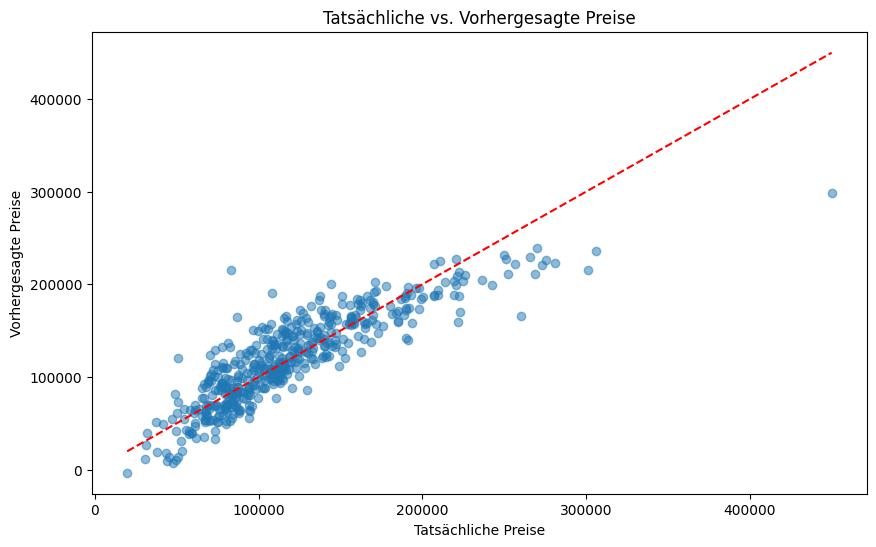

In [77]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_valid)

# Evaluierung der Vorhersagen (R² und MAE)
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# Visualisierung der tatsächlichen vs. vorhergesagten Preise
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise')
plt.show()

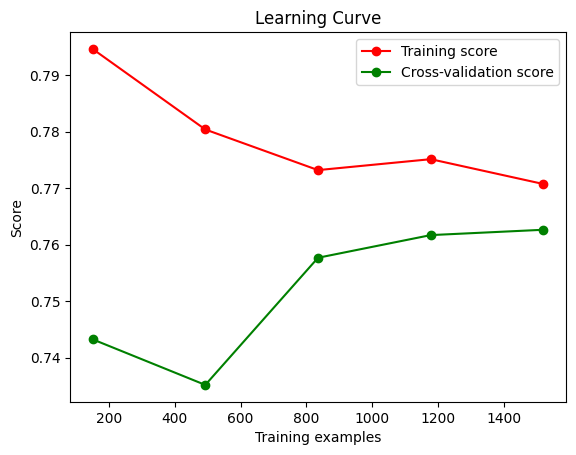

In [78]:
# Untersuchung von Verzerrung und Varianz
# Hier wird die Bias-Variance-Tradeoff-Analyse durchgeführt, um die Modellleistung zu verstehen.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(lin_reg, x_train, y_train, cv=5)

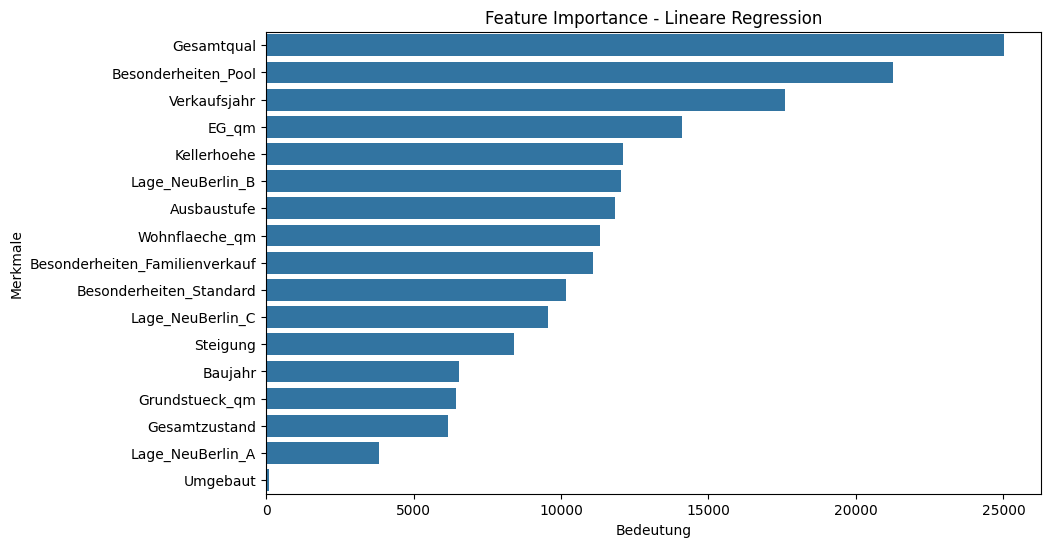

In [79]:
# Feature Importance für lineare Regression
feature_importance_lr = pd.Series(np.abs(lin_reg.coef_), index=x_train.columns)
feature_importance_lr = feature_importance_lr.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_lr.values, y=feature_importance_lr.index)
plt.title('Feature Importance - Lineare Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Die lineare Regression zeigt eine moderate Leistung bei der Vorhersage des Verkaufspreises. Der Mean Absolute Error (MAE) liegt bei etwa 19253 Euro, was darauf hinweist, dass die durchschnittliche Abweichung der Vorhersagen vom tatsächlichen Verkaufspreis relativ hoch ist. Der R²-Wert von 0.7519 deutet darauf hin, dass 75.19% der Varianz im Verkaufspreis durch die verwendeten Merkmale erklärt werden können. Allerdings zeigt das Modell auch Anzeichen von Underfitting, was darauf hindeutet, dass komplexere Modelle möglicherweise bessere Ergebnisse liefern könnten. Das Modell gewichtet insbesondere die Merkmale `Gesamtqual`, `Besonderheiten_Pool`, `Verkaufsjahr` und `EG_qm` als besonders wichtig für die Vorhersage des Verkaufspreises.

### 4.2.2 Entscheidungsbaumregression
Hier wird ein Entscheidungsbaumregressor trainiert und evaluiert.

In [80]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5)
dt_reg.fit(x_train, y_train)
y_pred_dt = dt_reg.predict(x_valid)

Mean Absolute Error (MAE) - Entscheidungsbaum: 18401.54033061085
R² Score - Entscheidungsbaum: 0.7300070280823631


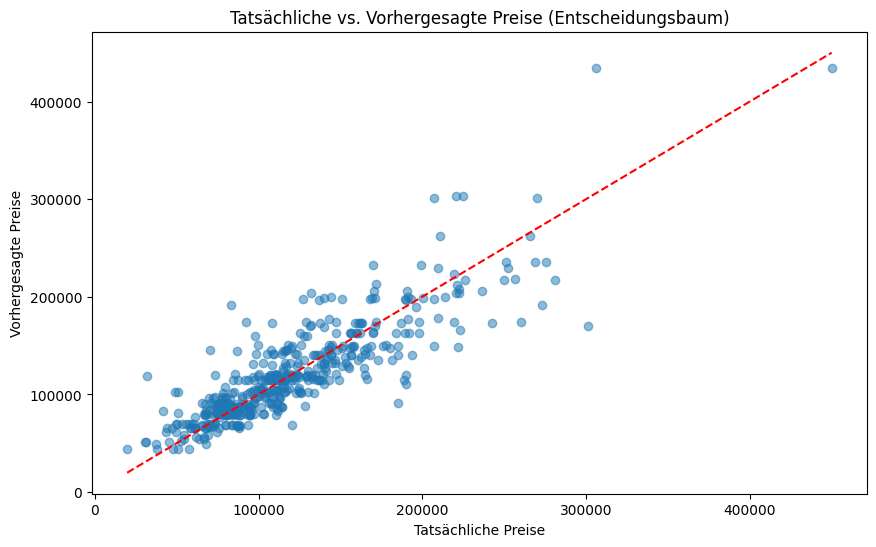

In [81]:
# Evaluierung der Vorhersagen des Entscheidungsbaumregressors
mae_dt = mean_absolute_error(y_valid, y_pred_dt)
r2_dt = r2_score(y_valid, y_pred_dt)

print(f'Mean Absolute Error (MAE) - Entscheidungsbaum: {mae_dt}')
print(f'R² Score - Entscheidungsbaum: {r2_dt}')

# Visualisierung der tatsächlichen vs. vorhergesagten Preise für Entscheidungsbaum
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_dt, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Entscheidungsbaum)')
plt.show()

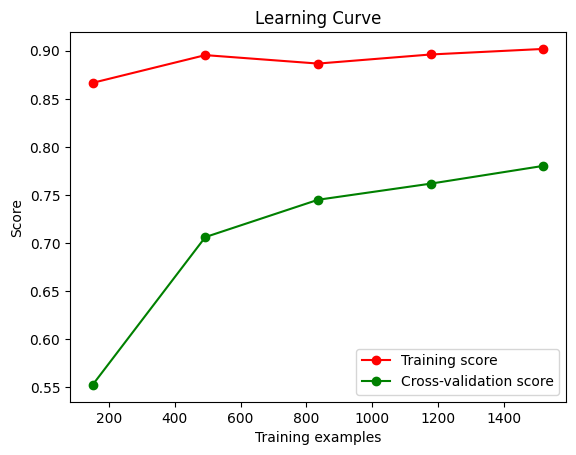

In [82]:
# Untersuchung von Verzerrung und Varianz
plot_learning_curve(dt_reg, x_train, y_train, cv=5)

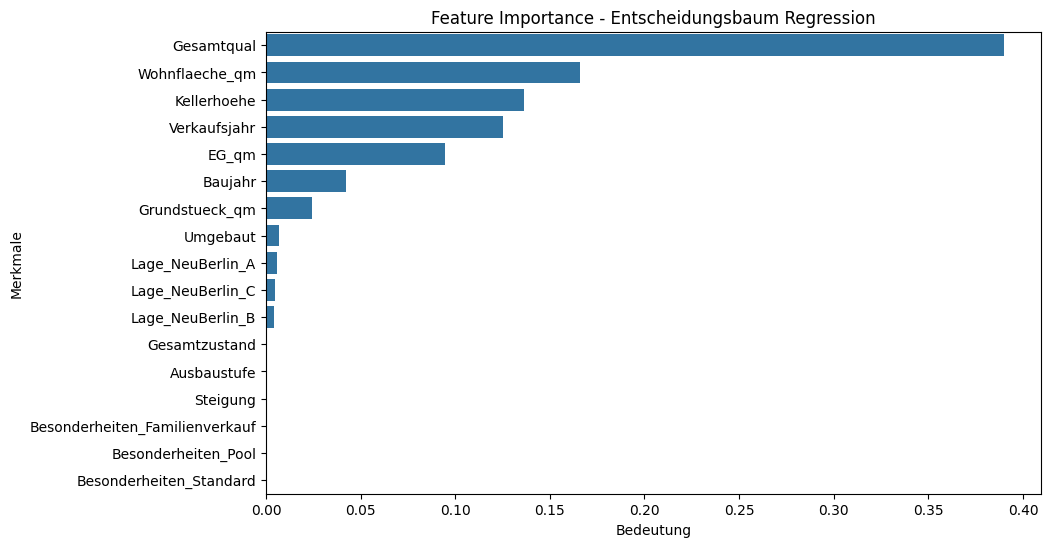

In [83]:
# Feature Importance für Entscheidungsbaum Regression
feature_importance_dt = pd.Series(dt_reg.feature_importances_, index=x_train.columns)
feature_importance_dt = feature_importance_dt.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_dt.values, y=feature_importance_dt.index)
plt.title('Feature Importance - Entscheidungsbaum Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Der Entscheidungsbaumregressor zeigt eine leicht verbesserte Leistung im Vergleich zur linearen Regression. Mit einem Mean Absolute Error (MAE) von etwa 18401 Euro und einem etwas geringeren R²-Wert von 0.73 kann das Modell den Verkaufspreis etwas genauer vorhersagen. Dies deutet darauf hin, dass der Entscheidungsbaum in der Lage ist, komplexere Zusammenhänge in den Daten zu erfassen. Allerdings besteht die Gefahr des Overfittings, insbesondere wenn der Baum zu tief wächst, daher wurde die maximale Tiefe des Baums auf 8 begrenzt sowie die Mindestanzahl der Samples für einen Split auf 10 und die Mindestanzahl der Samples für ein Blatt auf 5 gesetzt. Die Feature-Importance-Analyse zeigt, dass Merkmale wie `Gesamtqual`, `Verkaufsjahr` und `EG_qm` weiterhin eine bedeutende Rolle spielen, jedoch auch die Merkmale `Kellerhoehe` und `Wohnflaeche_qm` an Bedeutung gewonnen haben und zum Teil nun sogar eine höhere Bedeutung haben als die zuvor genannten Merkmale. Im Gegensatz zur linearen Regression gewichtet der Entscheidungsbaum andere Merkmale viel schwächer.

### 4.2.3 Random Forest Regression
Hier wird ein Random Forest Regressor trainiert und evaluiert.

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15)
rf_reg.fit(x_train, y_train)
y_pred_rf = rf_reg.predict(x_valid)

In [85]:
# Evaluierung der Vorhersagen des Random Forest Regressors
mae_rf = mean_absolute_error(y_valid, y_pred_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

print(f'Mean Absolute Error (MAE) - Random Forest: {mae_rf}')
print(f'R² Score - Random Forest: {r2_rf}')

Mean Absolute Error (MAE) - Random Forest: 14254.044441443366
R² Score - Random Forest: 0.8316887468036336


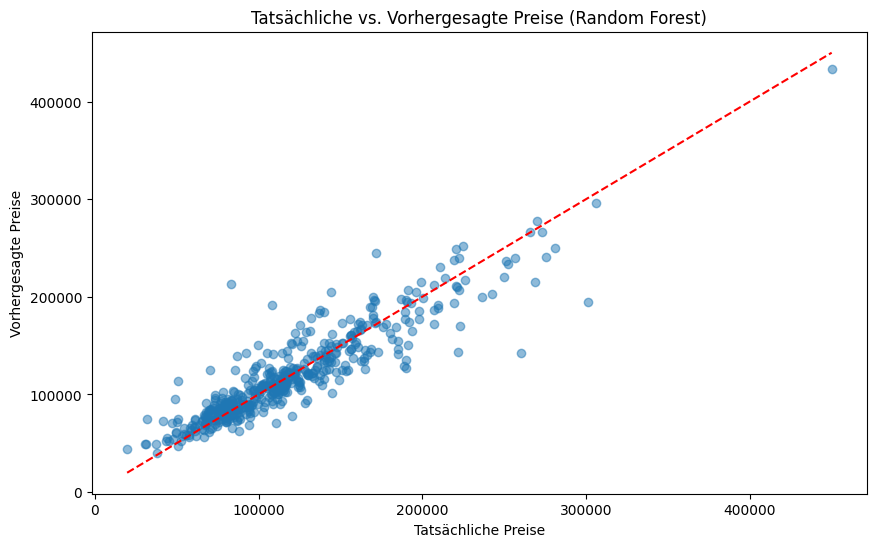

In [86]:
# Visualisierung der tatsächlichen vs. vorhergesagten Preise für Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_rf, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonale Linie
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Random Forest)')
plt.show()

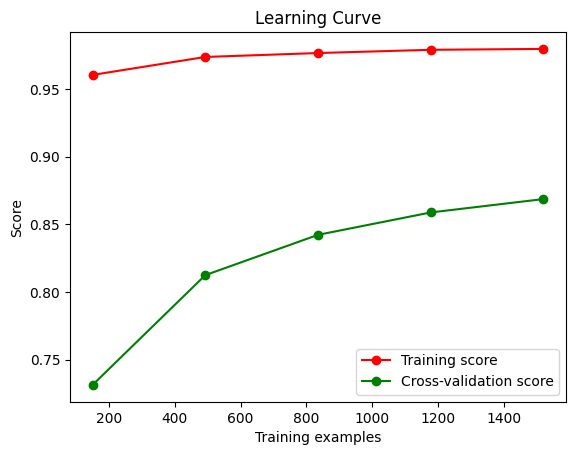

In [87]:
# Untersuchung von Verzerrung und Varianz
plot_learning_curve(rf_reg, x_train, y_train, cv=5)

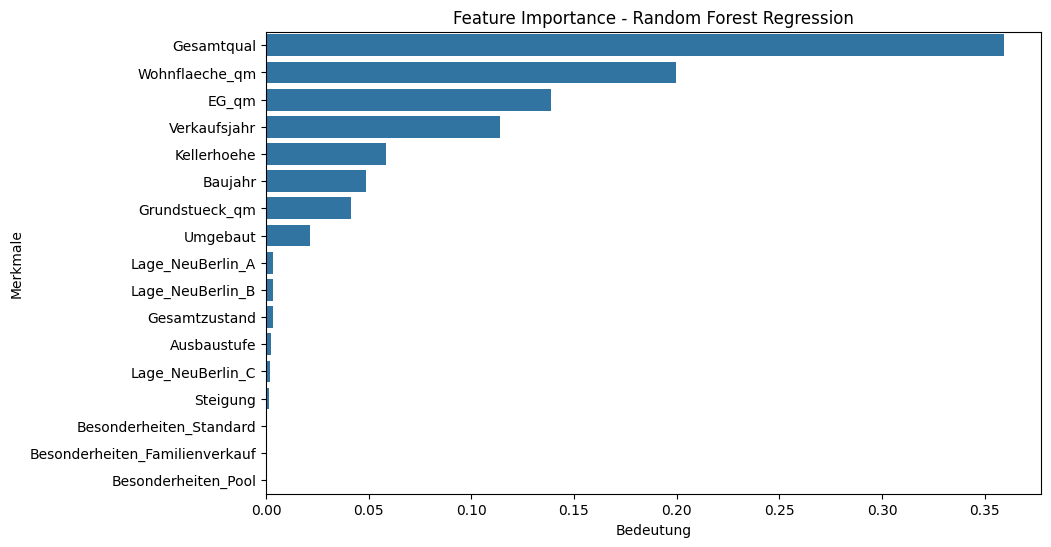

In [88]:
# Feature Importance für Random Forest Regression
feature_importance_rf = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feature_importance_rf = feature_importance_rf.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_rf.values, y=feature_importance_rf.index)
plt.title('Feature Importance - Random Forest Regression')
plt.xlabel('Bedeutung')
plt.ylabel('Merkmale')
plt.show()

**Auswertung:** Der Random Forest Regressor zeigt eine deutliche Verbesserung der Vorhersagegenauigkeit im Vergleich zu den vorherigen Modellen. Mit einem Mean Absolute Error (MAE) von etwa 14254 Euro und einem R²-Wert von 0.8317 kann das Modell den Verkaufspreis wesentlich genauer vorhersagen. Dies deutet darauf hin, dass der Random Forest in der Lage ist, komplexe Zusammenhänge in den Daten zu erfassen und gleichzeitig die Gefahr des Overfittings durch die Aggregation mehrerer Entscheidungsbäume zu minimieren. Die Feature-Importance-Analyse zeigt, dass Merkmale wie `Gesamtqual`, `Wohnflaeche_qm`, `EG_qm` und `Verkaufsjahr` weiterhin eine bedeutende Rolle spielen. Insgesamt zeigt der Random Forest Regressor die beste Leistung unter den getesteten Modellen und ist somit die bevorzugte Wahl für die Vorhersage des Immobilienverkaufspreises in diesem Datensatz.

## 4.3 Vorhersage auf dem Testset
Hier werden die finalen Vorhersagen auf dem zurückgehaltenen Testset durchgeführt.

In [92]:
y_pred_rf_test = rf_reg.predict(data_test)

print("Vorhersagen auf dem Testset abgeschlossen.")
print(f'Vorhersagen auf dem Testset:\n{y_pred_rf_test}')

Vorhersagen auf dem Testset abgeschlossen.
Vorhersagen auf dem Testset:
[101281.92891667 124475.07133333  87818.3114565   76157.24286475
  89280.58620399 127036.92833043  70363.70744048  53057.01775
 108749.4315437   91313.665       75373.01440171  75976.5412097
 149240.12013889 107873.64943816 110410.76309524 103668.04518803
 193839.985      216521.41333333 144111.16053922 106459.97137099
  75661.75620238  84662.52933333 194639.79043103  76234.19325893
  59552.37757143  73571.48110753  80617.58343573 124594.08959779
  84565.3741869   97899.62371429 109251.99075728 143993.57212772
  55197.512      178608.25097222  61819.71748413 113665.85865274
  77918.95347671 208684.365       96490.10776158 130074.15720758
 108460.04788869  82568.08928945 208499.8        128364.59606408
 152720.27595913  87593.92140476 122041.84696815  77329.19623499
  92167.48583333  87232.62431683  87642.902      140853.11872222
 107129.64531349  82056.38358462 285797.57833333  82666.98689281
 178905.67166667  8010

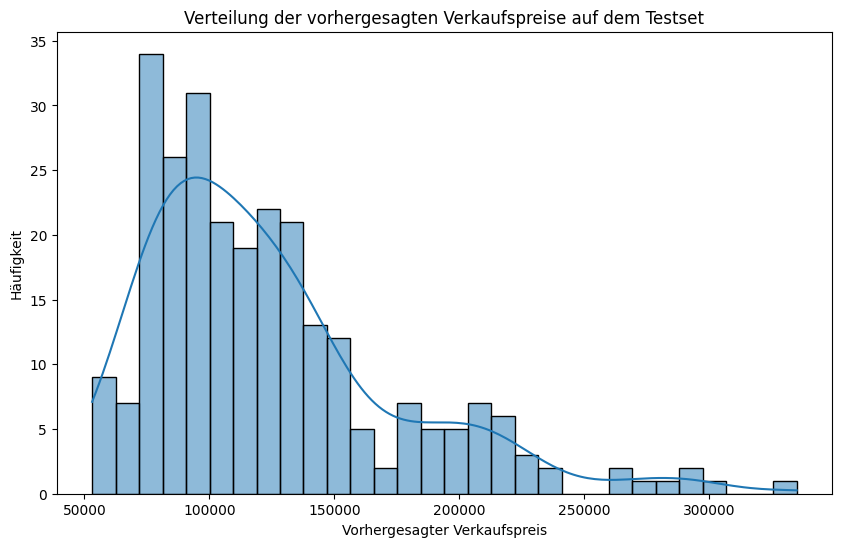

In [90]:
# Visualisierung der Verteilung der vorhergesagten Preise
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_rf_test, bins=30, kde=True)
plt.title('Verteilung der vorhergesagten Verkaufspreise auf dem Testset')
plt.xlabel('Vorhergesagter Verkaufspreis')
plt.ylabel('Häufigkeit')
plt.show()

In [91]:
# Speichern der Vorhersagen in der CSV-Datei data_for_test_filled.csv
data_test_filled = pd.read_csv('data_for_test.csv', sep=';')
data_test_filled['Z_Verkaufspreis'] = y_pred_rf_test.astype(int)
data_test_filled.to_csv('data_for_test_filled.csv', sep=';', index=False)
print("Vorhersagen wurden in 'data_for_test_filled.csv' gespeichert.")


Vorhersagen wurden in 'data_for_test_filled.csv' gespeichert.


# 5. Klassifikation

## 5.1 Vorbereitung der Daten für die Klassifikation

Für die Vorhersage der Lage einer Immobilie wird eine gesonderte Datenvorbereitung durchgeführt, da die Aufgabenstellung eine andere Zielvariable und einen eingeschränkten Merkmalsraum erfordert, im Gegensatz zur vorherige Analyse.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Auswahl der Einflussfaktoren (Verkaufspreis und Ausbaustufe)
data_for_classification = data_train[['Z_Verkaufspreis', 'Ausbaustufe']].copy()

# Wiederherstellung der Zielvariable (Lage)
# Da die das Merkmal Lage zuvor One-Hot-Encoded wurde, führen wir diese hier wieder zu einer einzigen Spalte zusammen, die den Namen der Lage enthält
y_dummies = data_train.filter(like='Lage_')
target = y_dummies.idxmax(axis=1)

# Skalierung aus Gründen wie in Kapitel 3.5 genannt
scaler_class = StandardScaler()
data_for_classification_scaled = scaler_class.fit_transform(data_for_classification)

# Datenset Splitten
x_train_cfc, x_test_cfc, y_train_cfc, y_test_cfc = train_test_split(
    data_for_classification_scaled, target, test_size=0.2, random_state=67
)

0       Lage_NeuBerlin_B
1       Lage_NeuBerlin_B
2       Lage_NeuBerlin_A
3       Lage_NeuBerlin_C
4       Lage_NeuBerlin_C
              ...       
2379    Lage_NeuBerlin_A
2380    Lage_NeuBerlin_C
2381    Lage_NeuBerlin_A
2382    Lage_NeuBerlin_A
2383    Lage_NeuBerlin_C
Length: 2374, dtype: object


## 5.2 Klassifikation mittels KNN und Entscheidungsbaum

In [ ]:
# Modell A: K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_cfc, y_train_cfc)
y_pred_knn = knn.predict(x_test_cfc)

In [ ]:
# Modell B: Entscheidungsbaum
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(x_train_cfc, y_train_cfc)
y_pred_dt = dt.predict(x_test_cfc)

## 5.3 Auswertung der Ergebnisse

In [113]:
print("Allgemein:")
print(f"Genauigkeit Modell 1 (KNN): {accuracy_score(y_test_cfc, y_pred_knn):.2%}")
print(f"Genauigkeit Modell 2 (Decision Tree): {accuracy_score(y_test_cfc, y_pred_dt):.2%}")

print('-' * 40)

print("\nDetail-Analyse (KNN):")
print(classification_report(y_test_cfc, y_pred_knn))

print('-' * 40)

print("\nDetail-Analyse (Entscheidungsbaum):")
print(classification_report(y_test_cfc, y_pred_dt))

Allgemein:
Genauigkeit Modell 1 (KNN): 46.53%
Genauigkeit Modell 2 (Decision Tree): 55.37%
----------------------------------------

Detail-Analyse (KNN):
                  precision    recall  f1-score   support

Lage_NeuBerlin_A       0.35      0.34      0.34       119
Lage_NeuBerlin_B       0.55      0.63      0.59       243
Lage_NeuBerlin_C       0.35      0.25      0.29       113

        accuracy                           0.47       475
       macro avg       0.41      0.40      0.41       475
    weighted avg       0.45      0.47      0.45       475

----------------------------------------

Detail-Analyse (Entscheidungsbaum):
                  precision    recall  f1-score   support

Lage_NeuBerlin_A       0.51      0.36      0.42       119
Lage_NeuBerlin_B       0.60      0.73      0.66       243
Lage_NeuBerlin_C       0.44      0.38      0.41       113

        accuracy                           0.55       475
       macro avg       0.52      0.49      0.50       475
    weig

Die durchgeführte Klassifikation der Wohnlage liefert folgende Genauigkeitswerte (Accuracy):
- KNN: 46.53%
- Entscheidungsbaum: 55.37%
Obwohl beide Modelle deutlich besser abschneiden als bloßes Raten (bei drei Klassen wäre die Zufallswahrscheinlichkeit bei ca. 33,3 %), ist eine Genauigkeit von rund 55 % für einen produktiven Einsatz nicht ausreichend. Die Detailanalyse der Classification-Reports offenbart die Gründe für dieses Ergebnis.

Einerseits erkennt das Modell die Klasse Lage_NeuBerlin_B verhältnismäßig gut (Recall: 0,73 bei Entscheidungsbaum, 0,63 bei KNN). Dies liegt daran, dass dies die häufigste Klasse ist (Support: 243) und sie wie in Kapitel 2 erkennbar das preisliche Mittelfeld abbildet. Das Modell lernt somit, dass es im Zweifel mit `Lage_NeuBerlin_B` am häufigsten richtig liegt.

Andererseits stellt sich ein Problem durch die mangelnde Trennschärfe bei den Rändern von A und C dar. A (Recall: 0,36 bei Entscheidungsbaum, 0,34 bei KNN) und C (Recall: 0,38 bei Entscheidungsbaum und 0,25 bei KNN) werden sehr schlecht erkannt. Das Modell übersieht also fast zwei Drittel der besten und schlechtesten Lagen. Ein höherer Preis kann entweder durch eine gute Lage (A) oder z.B. durch ein sehr großes Haus in einer mittleren Lage (B) entstehen. Ferner kann ein geringerer Preis durch eine schlechte Lage (C), oder durch ein kleineres Haus in mittlerer Lage (B) bedingt sein.

Letztens korreliert das zweite Merkmal `Ausbaustufe` kaum mit der geographischen Lage. Dies zeigt die folgende Feature-Importance der des Entscheidungsbaums anschaulich.

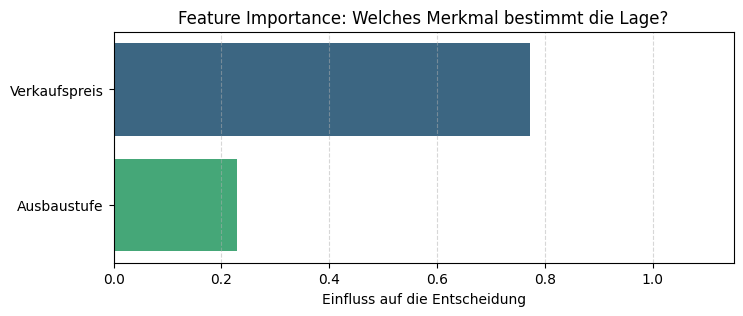

In [119]:
importances = dt.feature_importances_
features = ['Verkaufspreis', 'Ausbaustufe'] 
feature_df = pd.DataFrame({'Merkmal': features, 'Wichtigkeit': importances})
feature_df = feature_df.sort_values(by='Wichtigkeit', ascending=False)

plt.figure(figsize=(8, 3))

ax = sns.barplot(x='Wichtigkeit', y='Merkmal', data=feature_df, palette='viridis')

plt.title('Feature Importance: Welches Merkmal bestimmt die Lage?')
plt.xlabel('Einfluss auf die Entscheidung')
plt.ylabel('')
plt.xlim(0, 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

## 5.4 Fazit
Das Experiment belegt, dass der Kaufpreis und die Anzahl der Stockwerke allein ungeeignete Merkmale für die Lagebestimmung sind. Für eine zufriedenstellende Klassifikation wäre zumindest die Wohnfläche, beispielsweise zur Berechnung des Quadratmeterpreises, erforderlich.